In [61]:
stopwords = list(set([
    '이', '가', '은', '는', '을', '를', '의', '에', '에서', '에게', '께', '로', '으로', 
    '와', '과', '보다', '처럼', '만큼', '같이', '까지', '마저', '조차', '부터', 
    '이나', '나', '이며', '며', '등', '하다', '한다', '하고', '하니', '하면', 
    '되어', '되다', '되고', '되니', '입니다', '습니다', 'ㅂ니다', '어요', '아요', '다', '방이', '제대로',
    '고', '면', '게', '지', '죠',
    '그리고', '그러나', '하지만', '그런데', '그래서', '그러면', '그러므로', '따라서', 
    '또한', '또는', '및', '즉', '한편', '반면에', '근데',
    '나', '저', '우리', '저희', '너', '너희', '당신', '그', '그녀', '그들', '누구', '그렇다',
    '무엇', '어디', '언제', '어느', '이것', '그것', '저것', '여기', '거기', '저기', 
    '이쪽', '그쪽', '저쪽',
    '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '열',
    '일', '이', '삼', '사', '오', '육', '칠', '팔', '구', '십', '백', '천', '만',
    '첫째', '둘째', '셋째',
    '바로', '때', '것', '수', '문제', '경우', '부분', '이다',
    '내용', '결과', '자체', '가지',
    '않았어요', '있었어요', '했어요', '했는데요', '있는데요', '합니다', '없다', '나다','생각하다',
    '했다', '같다', '네요','아니다',
    '좀', '너무', '정말', '많이', '조금',
    '사장', '이용', '용하다', '물이',
    '뿐', '대로', '만', '따름', '나름', '김에', '터',
    '아', '아이고', '아이구', '아하', '어', '그래', '응', '네', '예', '아니', '않다', '안되다','안','그냥',
    '가다', '오다', '주다', '말다', '나다', '받다', '알다', '모르다', '싶다', '생각하다', '들다'
]))

stopwords = set(w.lower() for w in stopwords)


In [62]:
from functools import partial
from konlpy.tag import Okt
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. 데이터 불러오기 (중립 제거 포함)
train_df = pd.read_csv("ratings_train.csv", encoding="utf-8-sig")
test_df = pd.read_csv("ratings_test.csv", encoding="utf-8-sig")

train_df = train_df[train_df["label"].isin([0, 1])]
test_df = test_df[test_df["label"].isin([0, 1])]

X_train_text = train_df["text"]
y_train = train_df["label"]
X_test_text = test_df["text"]
y_test = test_df["label"]

# 2. ✅ 형태소 분석기 + tokenizer 함수 정의
okt = Okt()

def tokenize(text, stopwords=[]):
    try:
        return [
            word.lower()
            for word, pos in okt.pos(text, stem=True)
            if pos in ['Noun', 'Adjective']
            and word.lower() not in stopwords
            and len(word) > 1
        ]
    except Exception as e:
        print(f"Tokenization error: {e}")
        return []

# def tokenize(text):
#     try:
#         return [
#             word for word, pos in okt.pos(text, stem=True)
#             if pos in ['Noun', 'Adjective', 'Verb']
#             and word not in stopwords
#             and len(word) > 1  # ✅ 1글자 제거
#         ]
#     except:
#         return []
# ✅ partial을 사용해 stopwords 고정
tokenizer_with_stopwords = partial(tokenize, stopwords=stopwords)


# 3. ✅ TF-IDF 벡터화 with tokenizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer_with_stopwords, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# 4. 모델 학습
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# 5. 평가
y_pred = model.predict(X_test)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))


c:\Users\MYCOM\.conda\envs\azen\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


=== Confusion Matrix ===
[[185  36]
 [ 72 206]]

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.720     0.837     0.774       221
           1      0.851     0.741     0.792       278

    accuracy                          0.784       499
   macro avg      0.786     0.789     0.783       499
weighted avg      0.793     0.784     0.784       499



In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# 1. 단어 리스트 및 가중치
feature_names = np.array(vectorizer.get_feature_names_out())
coef = model.coef_[0]  # 이진 분류이므로 shape (1, n_features)

# 2. 긍정/부정 top 단어 인덱스 추출
topn = 30
top_pos_idx = np.argsort(coef)[::-1][:topn]
top_neg_idx = np.argsort(coef)[:topn]

# 3. 긍정 / 부정 단어별 가중치 딕셔너리 생성
word_weights = {
    1: dict(zip(feature_names[top_pos_idx], coef[top_pos_idx])),
    0: dict(zip(feature_names[top_neg_idx], coef[top_neg_idx])),
}

In [64]:
def draw_wordcloud(word_weight_dict, title, color='Greens'):
    wc = WordCloud(
        font_path='C:/Windows/Fonts/NanumGothic.ttf',  # Mac은 AppleGothic, Linux는 나눔폰트
        background_color='white',
        colormap=color,
        width=800,
        height=400
    )
    wc.generate_from_frequencies(word_weight_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

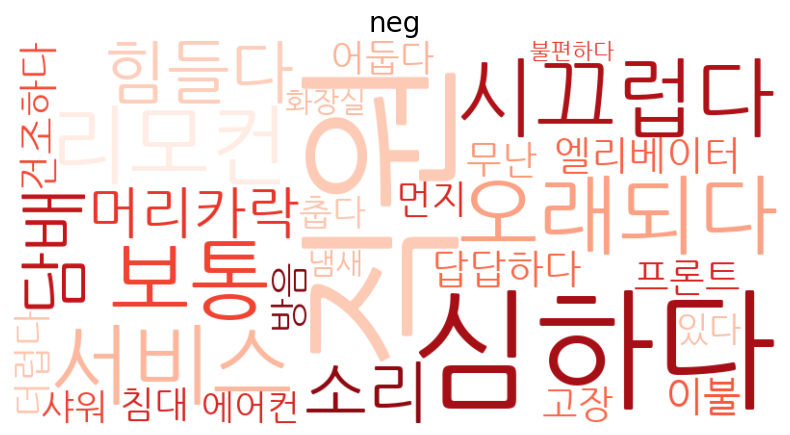

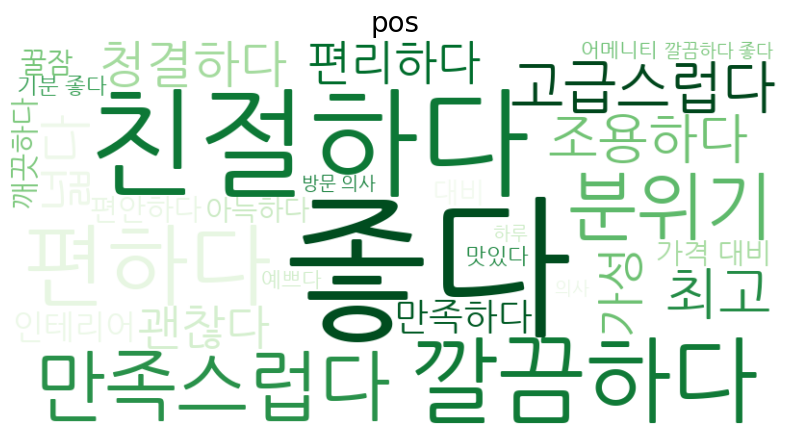

In [65]:
draw_wordcloud(word_weights[0], 'neg', color='Reds')
draw_wordcloud(word_weights[1], 'pos', color='Greens')

In [67]:
new_texts = ["잠은 잘 잤는데 냄새났어요", "서비스는 좋은데 시설이 별로였어요"]
X_new = vectorizer.transform(new_texts)
pred = model.predict(X_new)
proba = model.predict_proba(X_new)

for i, text in enumerate(new_texts):
    print(f"문장: {text}")
    print(f"예측: {pred[i]}, 확률: {proba[i]}")

문장: 잠은 잘 잤는데 냄새났어요
예측: 0.0, 확률: [0.77120666 0.22879334]
문장: 서비스는 좋은데 시설이 별로였어요
예측: 1.0, 확률: [0.4970578 0.5029422]


In [ ]:
# 5. 저장
# joblib.dump(model, 'Logistic_model.pkl')
# joblib.dump(vectorizer, 'Logistic_tfidf_vectorizer.pkl')
# print("✅ 모델 및 벡터라이저 저장 완료!")

In [ ]:
from wordcloud import WordCloud

# 워드클라우드용 단어 + 가중치 딕셔너리 만들기
word_weights = {
    label: dict(zip(df['word'], df['weight']))
    for label, df in weights.items()
}
print(word_weights.keys())

# 워드클라우드 그리기 함수
def draw_wordcloud(word_weight_dict, title, color):
    wc = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
        background_color='white',
        colormap=color,
        width=800,
        height=400
    )
    wc.generate_from_frequencies(word_weight_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# 클래스별 워드클라우드 출력
draw_wordcloud(word_weights[0], '부정 감성 주요 단어', 'Reds')
draw_wordcloud(word_weights[1], '긍정 감성 주요 단어', 'Greens')


In [68]:
# 새 문장 리스트
df = pd.read_csv('36000_reviews.csv')

sentence = df['sentence']

# 벡터화 (학습한 vectorizer 사용)
X_new = vectorizer.transform(sentence)

# 예측 수행
predictions = model.predict(X_new)
probs = model.predict_proba(X_new)

threshold = 0.6
for i, text in enumerate(sentence):
    prob_pos = probs[i][1]
    if prob_pos >= threshold:
        label = "긍정"
    elif prob_pos <= 1 - threshold:
        label = "부정"
    else:
        label = "모호"
    
    print(f"문장: {text}")
    print(f"예측 감성: {label} (긍정 확률: {prob_pos:.3f})\n")

KeyboardInterrupt: 